In [1]:
_ = """
Copyright 2021 The Collocated Irradiance Network Authors.

Licensed under the Apache License, Version 2.0 (the "License");                                                         
you may not use this file except in compliance with the License.                                                        
You may obtain a copy of the License at                                                                                 
                                                                                                                        
    https://www.apache.org/licenses/LICENSE-2.0                                                                         
                                                                                                                        
Unless required by applicable law or agreed to in writing, software                                                     
distributed under the License is distributed on an "AS IS" BASIS,                                                       
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.                                                
See the License for the specific language governing permissions and                                                     
limitations under the License.
"""

In [ ]:
!pip install xarray[complete]

In [ ]:
!pip install gcsfs

In [ ]:
import xarray
import matplotlib.pyplot as plt

# Read irradiances in zarr format

In [6]:
CERES_GOES_VERSION = '2022_04_25_1650910589'

In [7]:
coin = xarray.open_zarr(f'gs://upwelling_irradiance/ceres_goes/{CERES_GOES_VERSION}/2018/021/16/s20180211630395_olr', consolidated=True)
coin

<xarray.Dataset>
Dimensions:                 (x: 5424, x_image_bounds: 2, y: 5424, y_image_bounds: 2)
Coordinates:
    t                       datetime64[ns] ...
  * x                       (x) float32 -0.1518 -0.1518 ... 0.1518 0.1518
    x_image                 float32 ...
  * x_image_bounds          (x_image_bounds) float64 -0.1519 0.1519
  * y                       (y) float32 0.1518 0.1518 0.1517 ... -0.1518 -0.1518
    y_image                 float32 ...
  * y_image_bounds          (y_image_bounds) float64 0.1519 -0.1519
Data variables:
    goes_imager_projection  int32 ...
    predicted_olr           (y, x) float32 dask.array<chunksize=(339, 678), meta=np.ndarray>

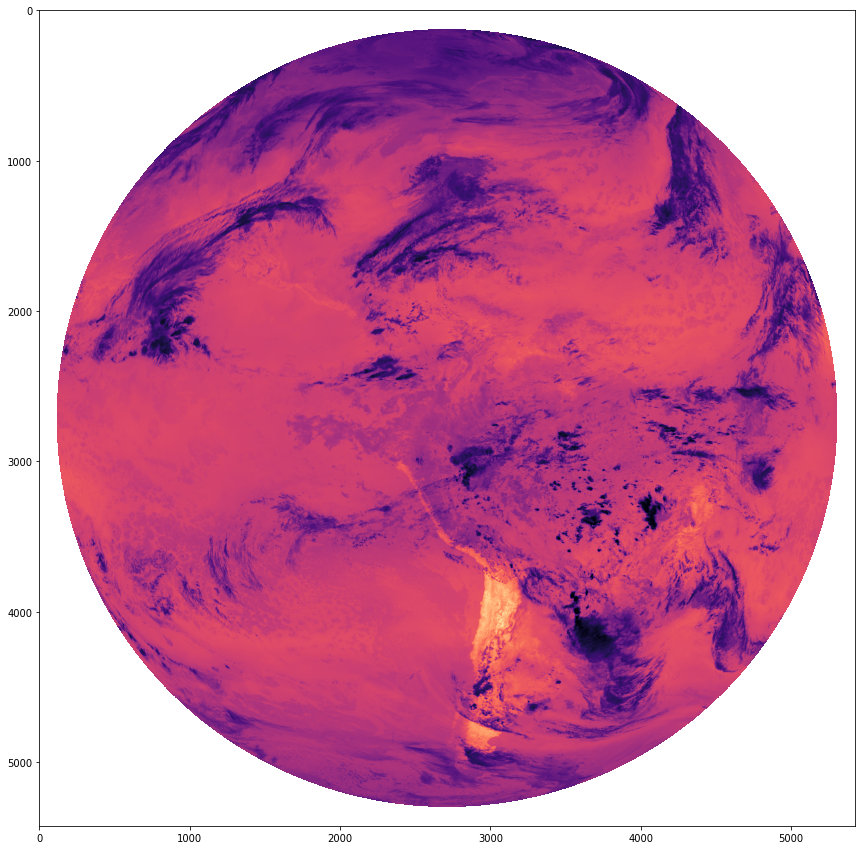

In [8]:
plt.figure(figsize=(15,15))
plt.imshow(coin.predicted_olr, cmap='magma')

# Read tfrecord training/validation data

In [9]:
import tensorflow as tf

In [10]:
tf.io.FixedLenFeature([], tf.string).dtype == tf.string

True

In [11]:
spec = {
    'surface_type_index': tf.io.FixedLenFeature([], tf.string),
    'surface_type_percent_coverage': tf.io.FixedLenFeature([], tf.string),
    'psf_weights': tf.io.FixedLenFeature([], tf.string),
    'goes_lats': tf.io.FixedLenFeature([], tf.string),
    'goes_lngs': tf.io.FixedLenFeature([], tf.string),
    'goes_timestamp': tf.io.FixedLenFeature([], tf.int64),
    'ceres_timestamp': tf.io.FixedLenFeature([], tf.int64),
    'ceres_olr': tf.io.FixedLenFeature([], tf.float32),
    'ceres_rsr': tf.io.FixedLenFeature([], tf.float32),
}
for channel in range(1, 17):
  spec[f'goes_channel_{channel}'] = tf.io.FixedLenFeature([], tf.string)

def _parse_examples(serialized):
  return tf.io.parse_example(serialized, spec)

validation_dataset = tf.data.TFRecordDataset(
    f'gs://upwelling_irradiance/ceres_goes/{CERES_GOES_VERSION}/training_and_validation_data/before_20190402/validation.tfrecords-00000-of-00100')
validation_dataset = validation_dataset.map(_parse_examples, num_parallel_calls=tf.data.AUTOTUNE)

# Meta features are useful for analysis of model bias on subsets of the data.
META_FEATURE_NAMES = ('ceres_latitude', 'ceres_longitude',
                      'ceres_viewing_zenith', 'ceres_relative_azimuth',
                      'ceres_solar_zenith', 'calculated_solar_zenith')

for feature_name in META_FEATURE_NAMES:
  spec[feature_name] = tf.io.FixedLenFeature([], tf.float32)


def _parse_tensors(features):
  for feature_name in features:
    if spec[feature_name].dtype == tf.string:
      features[feature_name] = tf.io.parse_tensor(
          features[feature_name], out_type=tf.float32)
          
  return features

validation_dataset = validation_dataset.map(_parse_tensors, num_parallel_calls=tf.data.AUTOTUNE)

for features in validation_dataset.take(1):
  break

features

{'ceres_olr': <tf.Tensor: shape=(), dtype=float32, numpy=202.84843>,
 'ceres_rsr': <tf.Tensor: shape=(), dtype=float32, numpy=208.16934>,
 'ceres_timestamp': <tf.Tensor: shape=(), dtype=int64, numpy=1554675073>,
 'goes_channel_1': <tf.Tensor: shape=(1700,), dtype=float32, numpy=
 array([185.211  , 168.76587, 166.32953, ...,   0.     ,   0.     ,
          0.     ], dtype=float32)>,
 'goes_channel_10': <tf.Tensor: shape=(1700,), dtype=float32, numpy=
 array([8.463301, 8.643673, 8.403177, ..., 0.      , 0.      , 0.      ],
       dtype=float32)>,
 'goes_channel_11': <tf.Tensor: shape=(1700,), dtype=float32, numpy=
 array([22.381832, 23.515997, 23.149061, ...,  0.      ,  0.      ,
         0.      ], dtype=float32)>,
 'goes_channel_12': <tf.Tensor: shape=(1700,), dtype=float32, numpy=
 array([24.53735 , 25.299511, 24.86399 , ...,  0.      ,  0.      ,
         0.      ], dtype=float32)>,
 'goes_channel_13': <tf.Tensor: shape=(1700,), dtype=float32, numpy=
 array([43.35296 , 45.593674, 4